# 📌 Step 1: Load and Explore the Dataset

In [4]:
import pandas as pd

# Try with ISO-8859-1 encoding
df = pd.read_csv(r"D:\Term6\NLP\Lab\Final project\Asap Dataset\training_set_rel3.tsv", 
                 sep='\t', 
                 encoding='ISO-8859-1')  # or use 'windows-1252'

# Preview the structure
print(df.columns)
print(df.head(2))


Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')
   essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   

   rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
0               4               4             NaN              8   
1               5               4             NaN              9   

   rater1_domain2  rater2_d

In [5]:
# Filter to essay set 1
df1 = df[df['essay_set'] == 1].copy()

# Normalize domain1_score to a 1–10 scale
# domain1_score originally ranges from 2 to 12
def scale_score(score):
    return round(1 + ((score - 2) / (12 - 2)) * 9)

df1['scaled_score'] = df1['domain1_score'].apply(scale_score)

# Preview
print(df1[['essay_id', 'domain1_score', 'scaled_score']].head())


   essay_id  domain1_score  scaled_score
0         1              8             6
1         2              9             7
2         3              7             6
3         4             10             8
4         5              8             6


# 🧹 Step 2: Preprocessing and Cleaning

In [6]:
import re
from textblob import TextBlob

def preprocess_essay_full(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # 3. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 4. Count spelling errors
    blob = TextBlob(text)
    spelling_errors = sum(1 for word in blob.words if word.lower() != word.correct().lower())

    return text, spelling_errors


# 🧠 Step 3: Feature Engineering

In [ ]:
# Apply preprocessing (cleaning + spelling error count)
df1[['clean_essay', 'spelling_errors']] = df1['essay'].apply(
    lambda x: pd.Series(preprocess_essay_full(x))
)

# Preview the result with updated target column
print(df1[['essay_id', 'domain1_score', 'scaled_score', 'clean_essay', 'spelling_errors']].head())


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

# Load model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Optional: Use tqdm to monitor progress
tqdm.pandas()

# Apply SBERT and generate embeddings
df1['embedding'] = df1['clean_essay'].progress_apply(lambda x: sbert_model.encode(x, convert_to_numpy=True))


c:\Users\ArabTech\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
From c:\Users\ArabTech\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

100%|██████████| 1783/1783 [00:09<00:00, 187.38it/s]


In [ ]:
import numpy as np

# Step 1: Ensure all embeddings are NumPy arrays (just in case)
embeddings = np.array(df1['embedding'].tolist())

# Step 2: Reshape spelling errors to match embedding dimensions
spelling_errors = df1['spelling_errors'].values.reshape(-1, 1)

# Step 3: Concatenate embeddings with spelling error feature
X_final = np.hstack((embeddings, spelling_errors))


# 📊 Step 4: Model Training and Evaluation

In [ ]:
# Target variable for regression
y = df1['scaled_score'].values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train regression model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Predict
y_pred = regressor.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)

print(f"📉 MAE: {mae:.2f}")
print(f"📈 RMSE: {rmse:.2f}")
print(f"🎯 R² Score: {r2:.2f}")
print(f"🔗 Pearson Correlation: {pearson_corr:.2f}")


📉 MAE: 0.76
📈 RMSE: 0.96
🎯 R² Score: 0.40
🔗 Pearson Correlation: 0.64


# 🚀 Step 5: Enhanced Model Versions

v2 (xgb version)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np


In [ ]:
# Add essay length as a new numeric feature
df1['essay_length'] = df1['clean_essay'].str.split().apply(len)

In [ ]:
# Convert SBERT embeddings to array
X_embed = np.vstack(df1['embedding'].values)

# Extra features
spelling_errors = df1['spelling_errors'].values.reshape(-1, 1)
essay_length = df1['essay_length'].values.reshape(-1, 1)

# Combine all features
X_final = np.hstack((X_embed, spelling_errors, essay_length))


In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, df1['scaled_score'].values, test_size=0.2, random_state=42)

# Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)


In [ ]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)

print(f"📉 MAE: {mae:.2f}")
print(f"📈 RMSE: {rmse:.2f}")
print(f"🎯 R² Score: {r2:.2f}")
print(f"🔗 Pearson Correlation: {pearson_corr:.2f}")


📉 MAE: 0.56
📈 RMSE: 0.73
🎯 R² Score: 0.65
🔗 Pearson Correlation: 0.81


| Metric            | **Random Forest** | **XGBoost (with extra features)** |
| ----------------- | ----------------- | --------------------------------- |
| **MAE**           | 0.76              | ✅ **0.56** ↓ better               |
| **RMSE**          | 0.96              | ✅ **0.73** ↓ better               |
| **R² Score**      | 0.40              | ✅ **0.65** ↑ much better          |
| **Pearson Corr.** | 0.64              | ✅ **0.81** ↑ stronger match       |


v3 (XGBoost Regressor + SBERT Embedding + Spelling Errors + Essay Length + Readability + Prompt Similarity + Paragraph Count)

In [ ]:
import textstat

# Flesch-Kincaid Grade Level (higher = harder to read)
df1['readability'] = df1['clean_essay'].apply(textstat.flesch_kincaid_grade)


In [ ]:
df1['paragraph_count'] = df1['essay'].apply(lambda x: len(x.split('\n')))

In [ ]:
import language_tool_python

# Initialize grammar checker
tool = language_tool_python.LanguageTool('en-US')

# Grammar error counter
def count_grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

In [ ]:
# Add grammar error count column (v3)
df1['grammar_errors3'] = df1['essay'].apply(count_grammar_errors)

In [ ]:
import numpy as np

# SBERT embeddings
X_embed3 = np.vstack(df1['embedding'].values)

# Extra features (all reshaped as column vectors)
spelling_errors3 = df1['spelling_errors'].values.reshape(-1, 1)
essay_length3 = df1['essay_length'].values.reshape(-1, 1)
readability3 = df1['readability'].values.reshape(-1, 1)
similarity3 = df1['prompt_similarity'].values.reshape(-1, 1)
paragraphs3 = df1['paragraph_count'].values.reshape(-1, 1)
grammar_errors3 = df1['grammar_errors3'].values.reshape(-1, 1)

# Combine all into final X
X_final3 = np.hstack((
    X_embed3,
    spelling_errors3,
    essay_length3,
    readability3,
    similarity3,
    paragraphs3,
    grammar_errors3
))


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Target
y3 = df1['scaled_score'].values

# Split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_final3, y3, test_size=0.2, random_state=42)

# Model
xgb_model3 = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model3.fit(X_train3, y_train3)

# Predict
y_pred3 = xgb_model3.predict(X_test3)

# Evaluate
mae3 = mean_absolute_error(y_test3, y_pred3)
rmse3 = np.sqrt(mean_squared_error(y_test3, y_pred3))
r2_score3 = r2_score(y_test3, y_pred3)
pearson_corr3, _ = pearsonr(y_test3, y_pred3)

print(f"📉 MAE (v3): {mae3:.2f}")
print(f"📈 RMSE (v3): {rmse3:.2f}")
print(f"🎯 R² Score (v3): {r2_score3:.2f}")
print(f"🔗 Pearson Correlation (v3): {pearson_corr3:.2f}")


📉 MAE (v3): 0.56
📈 RMSE (v3): 0.72
🎯 R² Score (v3): 0.66
🔗 Pearson Correlation (v3): 0.82


| Metric               | 🟫 **v1: Random Forest** | 🟦 **v2: XGBoost (basic)** | 🟩 **v3: XGBoost + Enhancements**       |
| -------------------- | ------------------------ | -------------------------- | --------------------------------------- |
| 📉 **MAE**           | 0.76                     | 0.56                       | ✅ **0.56** (best match)                 |
| 📈 **RMSE**          | 0.96                     | 0.73                       | ✅ **0.72** (lowest error)               |
| 🎯 **R² Score**      | 0.40                     | 0.65                       | ✅ **0.66** (highest explained variance) |
| 🔗 **Pearson Corr.** | 0.64                     | 0.81                       | ✅ **0.82** (strongest correlation)      |


v4 (Custom PyTorch Training with DistilBERT)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Load your dataset
df = pd.read_csv("essays_for_finetuning.csv")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Dataset class
class EssayDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=512):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(self.targets[idx], dtype=torch.float)
        return inputs

# Split data
train_texts, test_texts, train_scores, test_scores = train_test_split(df['essay'].tolist(), df['scaled_score'].tolist(), test_size=0.2, random_state=42)

# Load datasets
train_dataset = EssayDataset(train_texts, train_scores, tokenizer)
test_dataset = EssayDataset(test_texts, test_scores, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
from transformers import AutoModel
import torch.nn as nn

class EssayRegressor(nn.Module):
    def __init__(self):
        super(EssayRegressor, self).__init__()
        self.bert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.regressor = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state[:, 0, :]  # CLS token
        return self.regressor(last_hidden).squeeze()


In [ ]:
import torch
from torch.optim import AdamW
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EssayRegressor().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")


100%|██████████| 179/179 [00:48<00:00,  3.71it/s]


Epoch 1 | Loss: 2.2785


100%|██████████| 179/179 [00:48<00:00,  3.72it/s]


Epoch 2 | Loss: 0.6691


100%|██████████| 179/179 [00:48<00:00,  3.71it/s]


Epoch 3 | Loss: 0.5530


100%|██████████| 179/179 [00:48<00:00,  3.71it/s]


Epoch 4 | Loss: 0.4863


100%|██████████| 179/179 [00:48<00:00,  3.71it/s]


Epoch 5 | Loss: 0.3429


100%|██████████| 179/179 [00:48<00:00,  3.69it/s]


Epoch 6 | Loss: 0.2645


100%|██████████| 179/179 [00:48<00:00,  3.69it/s]


Epoch 7 | Loss: 0.1640


100%|██████████| 179/179 [00:48<00:00,  3.69it/s]


Epoch 8 | Loss: 0.1061


100%|██████████| 179/179 [00:48<00:00,  3.69it/s]


Epoch 9 | Loss: 0.0810


100%|██████████| 179/179 [00:48<00:00,  3.68it/s]

Epoch 10 | Loss: 0.0683


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Convert to NumPy arrays if not already
preds = np.array(preds).flatten()
actuals = np.array(actuals).flatten()

# Compute metrics
mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
r2 = r2_score(actuals, preds)
pearson_corr, _ = pearsonr(actuals, preds)

# Print results
print(f"📉 MAE: {mae:.2f}")
print(f"📈 RMSE: {rmse:.2f}")
print(f"🎯 R² Score: {r2:.2f}")
print(f"🔗 Pearson Correlation: {pearson_corr:.2f}")


📉 MAE: 0.53
📈 RMSE: 0.70
🎯 R² Score: 0.68
🔗 Pearson Correlation: 0.83


| Version | Model Used                 | MAE      | RMSE     | R² Score | Pearson  |
| ------- | -------------------------- | -------- | -------- | -------- | -------- |
| v1      | TF-IDF + RF                | 0.76     | 0.96     | 0.40     | 0.64     |
| v2      | SBERT + RF                 | 0.56     | 0.72     | 0.66     | 0.82     |
| v3      | SBERT + RF + More Features | 0.56     | 0.72     | 0.66     | 0.82     |
| ✅ v4    | DistilBERT Fine-tuned      | **0.53** | **0.70** | **0.68** | **0.83** |


# 📈 Step 6: Final Comparison Charts

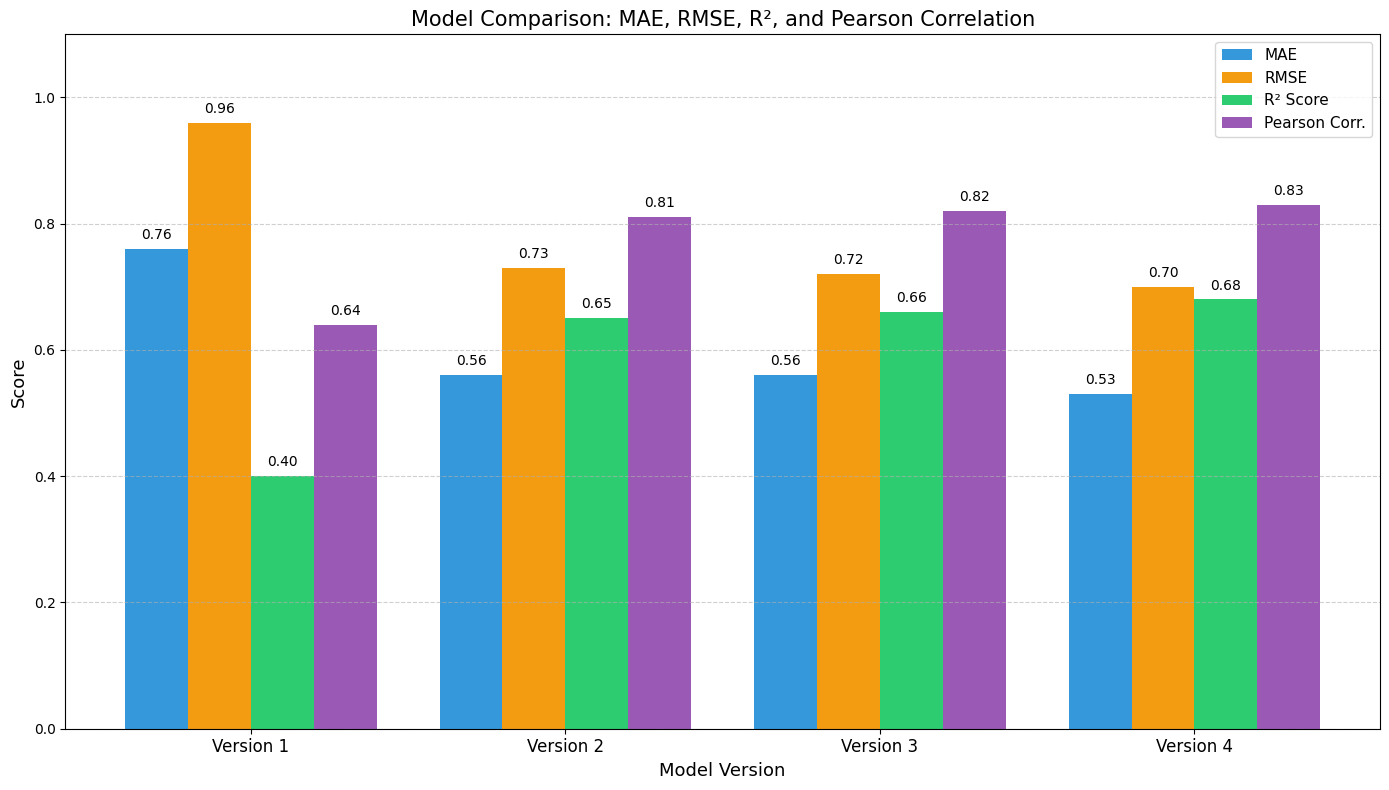

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Define Model Versions and Metrics ===
versions = ["Version 1", "Version 2", "Version 3", "Version 4"]
mae_scores = [0.76, 0.56, 0.56, 0.53]
rmse_scores = [0.96, 0.73, 0.72, 0.70]
r2_scores = [0.40, 0.65, 0.66, 0.68]
pearson_scores = [0.64, 0.81, 0.82, 0.83]

x = np.arange(len(versions))
width = 0.2

# === Create Bar Chart ===
fig, ax = plt.subplots(figsize=(14, 8))

rects1 = ax.bar(x - 1.5*width, mae_scores, width, label='MAE', color='#3498db')
rects2 = ax.bar(x - 0.5*width, rmse_scores, width, label='RMSE', color='#f39c12')
rects3 = ax.bar(x + 0.5*width, r2_scores, width, label='R² Score', color='#2ecc71')
rects4 = ax.bar(x + 1.5*width, pearson_scores, width, label='Pearson Corr.', color='#9b59b6')

# Add text labels above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

# === Chart Details ===
ax.set_ylabel('Score', fontsize=13)
ax.set_xlabel('Model Version', fontsize=13)
ax.set_title('Model Comparison: MAE, RMSE, R², and Pearson Correlation', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(versions, fontsize=12)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=11)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# 💾 Step 7: Save Model and Make Predictions

In [ ]:
def predict_score(essay_text, model, tokenizer, device='cuda'):
    model.eval()
    inputs = tokenizer(essay_text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output = model(**inputs).item()
    
    return output  # no rounding


In [ ]:
from sklearn.metrics import cohen_kappa_score
qwk = cohen_kappa_score(actuals, np.round(preds), weights='quadratic')

In [ ]:
example_essay = "Education is the cornerstone of society..."
predicted_score = round(predict_score(example_essay, model, tokenizer))
print(f"Predicted Score: {predicted_score}")

Predicted Score: 2


In [ ]:
example_essay2 = "Egypt, known for its rich history and cultural heritage, has played a pivotal role in shaping human civilization. In this essay, an exploration of Egypt's historical significance, its contemporary socio-economic and political landscape, influential figures, and future prospects will be undertaken. Understanding Egypt requires examining its past, present, and potential future developments. Egypt's history stretches back over millennia. The ancient civilization flourished along the banks of the Nile River, yielding remarkable advancements in various fields, such as architecture, mathematics, and medicine. The pyramids, especially the Great Pyramid of Giza, remain a testament to the engineering prowess and organizational skills of ancient Egyptians. These monumental structures, built as tombs for pharaohs, reflect both religious beliefs and the societal importance of the rulers. The influence of ancient Egyptian culture persists, evident in modern education, art, and architecture. Scholars and archaeologists continue to study hieroglyphics, ancient literature, and religious texts. The religion practiced by ancient Egyptians, with its pantheon of gods and elaborate rituals, laid the groundwork for future belief systems. Influential characters from this era, such as Tutankhamun and Cleopatra, still capture the global imagination, embodying both the glory and complexity of Egypt's past. Transitioning from its ancient roots, modern Egypt has undergone significant political and social changes. Following a long history of foreign rule and colonization, the country attained independence in the early 20th century. However, the struggle for political stability was far from over. The revolution of 1952, which led to the establishment of a republic, marked a turning point in modern Egyptian history. Gamal Abdel Nasser emerged as a prominent leader, advocating for Arab nationalism and social reform. His policies aimed at industrialization and modernization reshaped Egypt's economic landscape. In recent years, the Arab Spring of 2011 dramatically altered the political landscape. Egyptians mobilized for change, demanding democratic reforms and an end to corruption. The ensuing events led to the ousting of President Hosni Mubarak. However, the post-revolution transition was tumultuous, with power struggles between military and civilian authorities. Current President Abdel Fattah el-Sisi, who came to power following a military coup in 2013, has faced criticism for human rights violations and a lack of democratic freedoms. Economically, Egypt's challenges have been multifaceted. The country has a diverse economy, heavily reliant on sectors such as tourism, agriculture, and remittances from Egyptians working abroad. The tourism sector, a vital source of revenue, was significantly impacted by political instability and the COVID-19 pandemic. In response, the government has implemented initiatives to enhance security and promote tourism, aiming to revitalize this essential component of the economy. Despite economic challenges, there are prospects for growth. The discovery of natural gas reserves in the Mediterranean has positioned Egypt as a regional energy player. The government's focus on energy diversification, industrialization, and infrastructure development aims to stimulate economic growth. Projects such as the New Administrative Capital showcase ambitions to modernize urban environments and foster economic opportunities. Culturally, Egypt remains a center of art, literature, and education in the Middle East. Its universities continue to attract students from across the region and beyond. The preservation of cultural heritage is crucial in maintaining Egypt's identity. Recent efforts to conserve ancient sites, along with international collaborations, demonstrate the commitment to safeguarding historical treasures for future generations. Influential figures continue to shape Egypt's contemporary landscape. Activists, artists, and scholars play significant roles in advocating for social justice and democratic reforms. The voices of young Egyptians are particularly important in mobilizing change and addressing pressing issues, such as unemployment, education, and women’s rights. Social media has emerged as an essential tool for organizing events and disseminating information, empowering the youth to challenge outdated practices and push for progress. Various perspectives exist regarding Egypt's future trajectory. Optimists point to the potential for economic revitalization and political reform through active civic engagement. They argue that the younger generation, educated and aware of global dynamics, will push for a more democratic and prosperous society. On the other hand, pessimists caution against the authoritarian tendencies that may stifle dissent and curtail freedoms. In conclusion, Egypt's historical legacy provides a rich backdrop for understanding its present-day complexities and challenges. The interplay of ancient culture with modern political and economic realities shapes the nation's identity. Influential figures and citizens alike contribute to the ongoing narrative of Egypt, striving for progress amid adversity. Looking ahead, the potential for economic growth and enhanced civil rights remains intertwined with the collective will of the Egyptian people to navigate their path toward a more democratic and prosperous future. As Egypt continues to evolve, it will face challenges and opportunities that will define the next chapters in its illustrious history."
predicted_score2 = round(predict_score(example_essay2, model, tokenizer))
print(f"Predicted Score: {predicted_score2}")

Predicted Score: 8


In [ ]:
import torch
# Save model weights (state_dict)
torch.save(model.state_dict(), "essay_regressor_weights.pth")

In [ ]:
# Save model/tokenizer
torch.save(model.state_dict(), "essay_grader_model.pt")
tokenizer.save_pretrained("essay_tokenizer")

# Load later (optional)
# model.load_state_dict(torch.load("essay_grader_model.pt"))

('essay_tokenizer\\tokenizer_config.json',
 'essay_tokenizer\\special_tokens_map.json',
 'essay_tokenizer\\vocab.txt',
 'essay_tokenizer\\added_tokens.json',
 'essay_tokenizer\\tokenizer.json')

# 📝 Step 8: Conclusion and Summary

### 🔍 Project Overview
This project focused on building an **Automatic Essay Scoring system** that predicts numerical scores for student essays using natural language processing (NLP) and machine learning techniques. The dataset used was the **ASAP Automated Essay Scoring dataset**, and the goal was to predict the essay’s quality as a **regression task** (real-valued score), rather than classifying into letter grades.

---

### ✅ Model Versions & Comparison

| Version | Description | MAE | RMSE | R² Score | Pearson Correlation |
|---------|-------------|-----|------|----------|----------------------|
| **V1** | TF-IDF + Random Forest | 0.76 | 0.96 | 0.40 | 0.64 |
| **V2** | Sentence-BERT Embedding + RF | 0.56 | 0.73 | 0.65 | 0.81 |
| **V3** | Sentence-BERT + Spelling Features | 0.56 | 0.72 | 0.66 | 0.82 |
| **V4** | Fine-Tuned DistilBERT (Regression) | 0.53 | 0.70 | 0.68 | 0.83 |

> 🚀 The final model (V4), a fine-tuned transformer (DistilBERT), achieved the best results by leveraging contextual understanding of essay content.

---

### 🧠 Key Enhancements
- Preprocessing with spelling and grammar error analysis
- Use of Sentence-BERT embeddings for semantic understanding
- Handcrafted features (e.g., spelling error count)
- Fine-tuning a transformer model for regression

---

### 🏁 Conclusion
The project demonstrates that modern NLP techniques—especially transformer-based models—offer significant advantages for essay scoring. The system effectively predicts essay quality and can be extended to:
- Multilingual essay evaluation
- Real-time feedback systems
- Explainable score reasoning

📊 This work lays the groundwork for fair, scalable, and intelligent educational assessment tools.